In [1]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd

In [2]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
# sources = ["prefab4"]
sources = os.listdir(data_dir)
feat_dfs = []
label_dfs = []
for source in sources:
    # if source == "treebase_v1":
    #     continue
    feat_df = pd.read_parquet(data_dir / source / "features.parquet")
    label_df = pd.read_parquet(data_dir / source / "stats.parquet")
    label_df = label_df[["mean"]].query("method == 'dpos'").droplevel(2)
    feat_dfs.append(feat_df)
    label_dfs.append(label_df)

label_df = pd.concat(label_dfs, axis=0).sort_index()
# Scales up labels by ~5%
label_df = label_df / label_df.max()
feat_df = pd.concat(feat_dfs, axis=0).sort_index()
# feat_df = feat_df[top_feats[:20]]

cols = feat_df.columns
drop_cols = []
drop_cols = ["is_dna", "num_seqs"]
drop_cols += cols[cols.str.contains("seq_length")].to_list()
# drop_cols += cols[cols.str.contains("frst_chi-square")].to_list()
drop_df = feat_df[drop_cols].copy()
feat_df = feat_df.drop(drop_cols, axis=1, errors="ignore")

label_df = label_df.loc[feat_df.index]

print(feat_df.shape, label_df.shape)
assert (feat_df.index == label_df.index).all()

(11431, 469) (11431, 1)


In [3]:
# # # TEST PERFORMANCE ON WITHHELD DATA
# excluded = "sabre"
# dnaf_idxs = feat_df.query(f"source == '{excluded}'").index.copy()
# dnaf_feats = feat_df.loc[dnaf_idxs].copy()
# dnaf_labels = label_df.loc[dnaf_idxs].copy()
# feat_df = feat_df.drop(dnaf_idxs, axis=0)
# label_df = label_df.drop(dnaf_idxs, axis=0)

In [4]:
# test = feat_df.corr()["min:seq_length"]
# cols = feat_df.columns
# idxs = test.abs().argsort().to_numpy()[::-1]

# corr_df = pd.DataFrame(dict(feature=feat_df.columns, corr=test))
# corr_df = corr_df.iloc[idxs].reset_index(drop=True)
# corr_df[:5]

In [5]:
print("Shape:", feat_df.shape)
max_nan_col = feat_df.isna().sum().sort_values(ascending=False).iloc[[0]]
print("NaN max count: ", max_nan_col.index[0], "->", int(max_nan_col.iloc[0]))
print("NaN col share:", (feat_df.isna().any().mean()))
print(feat_df.columns[feat_df.isna().any()].to_list())
print()
print("NaN Rows:")
nan_mask = feat_df.isna().any(axis=1)
feat_df[nan_mask]

Shape: (11431, 469)
NaN max count:  iqr:9mer_ent -> 0
NaN col share: 0.0
[]

NaN Rows:


,,lower_bound_gap_percentage,min:js_char,max:js_char,mean:js_char,std:js_char,p1:js_char,p5:js_char,p10:js_char,p20:js_char,p30:js_char,...,p30:9mer_ent,p40:9mer_ent,p50:9mer_ent,p60:9mer_ent,p70:9mer_ent,p80:9mer_ent,p90:9mer_ent,p95:9mer_ent,p99:9mer_ent,iqr:9mer_ent
source,dataset,,,,,,,,,,,,,,,,,,,,,


In [6]:
print(f"Dropping {sum(nan_mask)} NaN rows...")
feat_df = feat_df[~nan_mask]
label_df = label_df[~nan_mask]

Dropping 0 NaN rows...


In [7]:
# print("max num seqs", drop_df["num_seqs"].max())
# print("max seq len", drop_df["max:seq_length"].max())

In [ ]:
from aldiscore import ROOT

use_lgb = True
RSTATE = 0

In [21]:
# Drop stuff
# feat_df = feat_df.loc[:, ~feat_df.columns.str.contains("tc_50")]
# feat_df = feat_df.loc[:, ~feat_df.columns.str.contains("tc_100")]
# feat_df = feat_df.loc[:, ~feat_df.columns.str.contains("tc_200")]
# feat_df = feat_df.loc[:, ~feat_df.columns.str.contains("tc_dist_scaled")]
# feat_df = feat_df.loc[:, ~feat_df.columns.str.contains("tc_dist_abs")]
# feat_df = feat_df.loc[:, ~feat_df.columns.str.contains("tc_dist_log")]
# feat_df = feat_df.loc[:, ~feat_df.columns.str.contains("tc_base")]

# top_feats = np.load(ROOT / "top_feats.npy", allow_pickle=True)
# feat_df = feat_df[top_feats]
feat_df.shape

(11431, 469)

In [22]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))

# sample = np.random.randint(0, len(label_df), int(len(label_df) * 0.7))
# train_idxs = label_df.iloc[sample].index
# test_idxs = feat_df.drop(feat_df.iloc[sample].index).index
# valid_idxs = test_idxs
assert len(set(train_idxs).intersection(set(test_idxs))) == 0

9144 1143 1144


In [23]:
if not use_lgb:
    from sklearn.ensemble import (
        RandomForestRegressor,
        GradientBoostingRegressor,
        HistGradientBoostingRegressor,
    )
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline
    from sklearn.feature_selection import SequentialFeatureSelector

    # top_30_feats = np.load(ROOT / "top_30_feats.npy", allow_pickle=True)
    # feat_df = feat_df[top_30_feats]

    model = HistGradientBoostingRegressor(
        max_features=0.1,
        max_depth=7,
        # learning_rate=0.05,
        max_leaf_nodes=None,
        max_iter=1000,
        # loss="absolute_error",
    )

    # model = RandomForestRegressor(
    #     n_estimators=100,
    #     max_features=0.1,
    #     max_depth=7,
    #     # learning_rate=0.05,
    #     max_leaf_nodes=None,
    #     # max_iter=100,
    #     # loss="absolute_error",
    # )

    # model = LinearRegression()
    # pipeline = Pipeline([("select", selector), ("model", model)])
    # model = GradientBoostingRegressor()
    # model = LinearRegression()

    pipeline = Pipeline([("model", model)])
    pipeline.fit(feat_df.loc[train_idxs], label_df.loc[train_idxs].to_numpy().ravel())
    y_pred = pipeline.predict(feat_df.loc[test_idxs]).clip(min=0, max=1)

In [24]:
if use_lgb:
    import lightgbm as lgb

    # Create LightGBM dataset
    train_data = lgb.Dataset(
        feat_df.loc[train_idxs],
        label=label_df.loc[train_idxs].to_numpy().ravel(),
    )
    test_data = lgb.Dataset(
        feat_df.loc[test_idxs],
        label=label_df.loc[test_idxs].to_numpy().ravel(),
    )
    valid_data = lgb.Dataset(
        feat_df.loc[valid_idxs],
        label=label_df.loc[valid_idxs].to_numpy().ravel(),
    )

    clean_feat_names = feat_df.columns.str.replace(":", "-").to_list()
    train_data = train_data.set_feature_name(clean_feat_names)
    test_data = test_data.set_feature_name(clean_feat_names)
    valid_data = valid_data.set_feature_name(clean_feat_names)
    # Set parameters for regression
    params = {
        "objective": "rmse",
        "learning_rate": 0.01,
        "metric": "l2,l1",
        "verbosity": 1,
        # "max_depth": 7,
        "seed": RSTATE,
        "num_leaves": 41,
        # "feature_fraction_bynode": 0.5,
        "feature_fraction": 0.2,
        "bagging_fraction": 0.67,
        # "bagging_freq": 5,
        # "early_stopping_rounds": 100,
        "num_threads": 2,
    }

    # Train the model
    num_round = 4000
    model = lgb.train(params, train_data, num_round, valid_sets=[valid_data])

In [25]:
y_pred = model.predict(feat_df.loc[valid_idxs])
y_true = label_df.loc[valid_idxs].to_numpy().ravel()
# mask = y_true > 0.1
# y_pred = y_pred[mask]
# y_true = y_true[mask]

# y_pred = model.predict(dnaf_feats)
# y_true = dnaf_labels.to_numpy().ravel()

In [26]:
eps = 1e-2

rmse = (((y_pred - y_true) ** 2).sum() / len(y_true)) ** 0.5
rmspe = (((y_pred - y_true) ** 2 / (y_true + eps)).sum() / len(y_true)) ** 0.5
mae = (np.abs(y_pred - y_true)).sum() / len(y_true)
mape = (np.abs(y_pred - y_true) / (y_true + eps)).sum() / len(y_true)
mape_p50 = np.percentile(np.abs(y_pred - y_true) / (y_true + eps), 50)
corr = np.corrcoef(y_true, y_pred)[0, 1]
print(f"[RMSE] {rmse:.4f}")
print(f"[RMSPE] {rmspe:.4f}")
print(f"[MAE] {mae:.4f}")
print(f"[MAPE] {mape:.4f}")
print(f"[MAPE_P50] {mape_p50:.4f}")
print(f"[CORR] {corr:.4f}")
print(np.sort(np.abs(y_pred - y_true) / (y_true + eps))[::-1][:20])

[RMSE] 0.0419
[RMSPE] 0.1069
[MAE] 0.0246
[MAPE] 0.2641
[MAPE_P50] 0.1612
[CORR] 0.9722
[9.04442052 5.82110147 5.57646734 4.23105826 2.65054538 2.24606579
 1.99231825 1.90043671 1.88259194 1.82282125 1.761447   1.68157768
 1.67614585 1.62106525 1.60813988 1.56685491 1.52652053 1.45628526
 1.3452039  1.32296387]


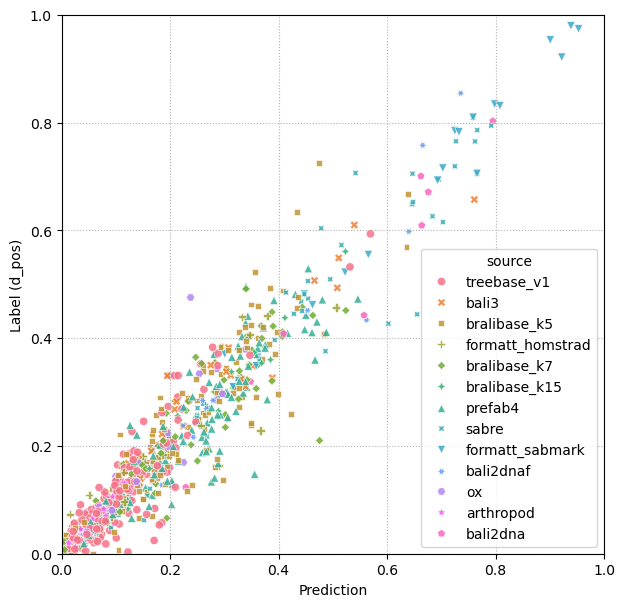

In [27]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[valid_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 7))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

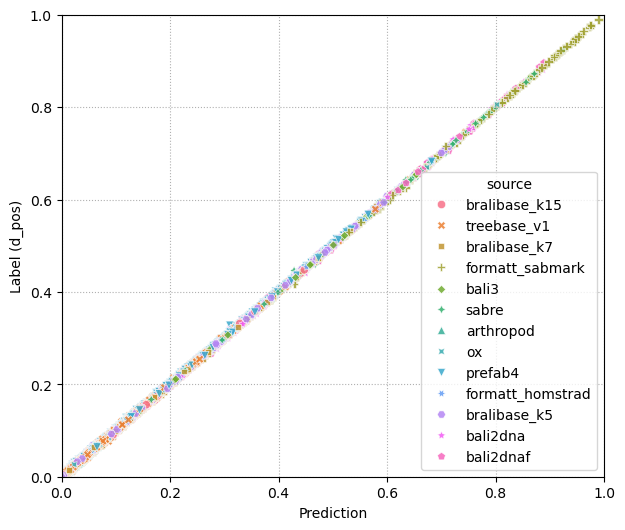

In [28]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(
    x=model.predict(feat_df.loc[train_idxs]),
    y=label_df.loc[train_idxs].to_numpy().ravel(),
    alpha=0.85,
    style=sources,
    hue=sources,
)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

In [29]:
test = feat_df.copy()
test["label"] = label_df["mean"]
corr = test.corr().loc["label"]
corr = corr.iloc[corr.abs().argsort()[::-1]]
corr[:20]

label                1.000000
p70:tc_base_p50     -0.885261
p70:tc_base_mean    -0.883455
p70:tc_base_min     -0.882662
mean:tc_base_p50    -0.882356
p60:tc_base_p50     -0.882130
mean:tc_base_mean   -0.881187
p60:tc_base_mean    -0.881015
mean:tc_base_max    -0.880528
p70:tc_base_max     -0.879801
mean:tc_base_min    -0.879684
p60:tc_base_max     -0.879450
p60:tc_base_min     -0.879217
p50:tc_base_p50     -0.874936
p50:tc_base_mean    -0.874196
p50:tc_base_max     -0.874180
p80:tc_base_p50     -0.872961
p50:tc_base_min     -0.872034
p80:tc_base_min     -0.871198
p80:tc_base_mean    -0.870324
Name: label, dtype: float64

In [30]:
if use_lgb:
    imps = model.feature_importance(importance_type="gain")
else:
    imps = model.feature_importances_
imp_df = pd.DataFrame(dict(feature=feat_df.columns, importance=imps))
imp_df = imp_df.sort_values("importance", ignore_index=True, ascending=False)
imp_df[:10]
imp_df[imp_df.feature.str.contains("mer")].iloc[:10]
# np.save(ROOT / "top_feats.npy", imp_df.feature[:50].to_numpy())

AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

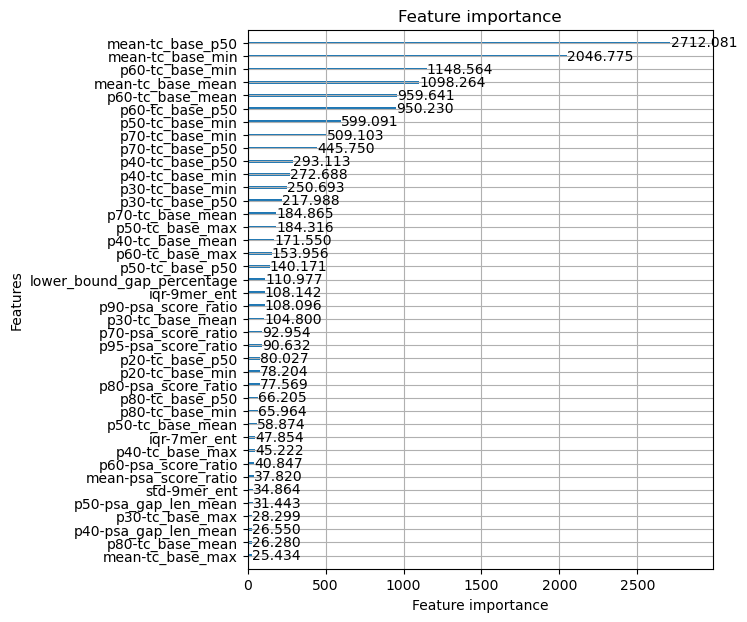

In [ ]:
if use_lgb:
    lgb.plot_importance(
        model, figsize=(6, 7), importance_type="gain", max_num_features=40
    )
else:
    pass
    # sn.barplot(x=feat, y=importance[sort_idxs], hue=is_tc)
    # ax = plt.gca()
    # _ = ax.set_xticklabels([])
    # _ = ax.legend(title="Consistency-based")
    # _ = ax.set_ylabel("Feature importance")
    # _ = ax.set_xlabel("Features")
    # print(top_feats[:30])